In [1]:
# !pip install -q git+https://github.com/tensorflow/examples.git
#https://github.com/christianversloot/machine-learning-articles/blob/main/how-to-build-a-u-net-for-image-segmentation-with-tensorflow-and-keras.md

In [1]:
import tensorflow as tf
import numpy as np
from glob import glob
from commons import load_images_from_directory_resize
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from skimage.io import imread
from skimage.transform import resize

2022-04-24 22:45:43.359397: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-04-24 22:45:43.359418: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
from __future__ import absolute_import, division, print_function, unicode_literals
from tensorflow_examples.models.pix2pix import pix2pix
import tensorflow_datasets as tfds
tfds.disable_progress_bar()
from IPython.display import clear_output
import matplotlib.pyplot as plt
from commons import plot
from keras import backend as K

In [16]:
from commons import binarize_image

In [3]:
def create_mask(pred_mask):
    
    pred_mask = tf.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    
    return np.asarray(pred_mask).reshape(DIM, DIM)

In [4]:
OUTPUT_CHANNELS = 3
DIM = 224

In [97]:
def unet_model(output_channels):
    
    base_model = tf.keras.applications.MobileNetV2(input_shape=[DIM, DIM, 3], include_top=False)

    # Use as ativações dessas camadas
    layer_names = [
        'block_1_expand_relu',   # 64x64
        'block_3_expand_relu',   # 32x32
        'block_6_expand_relu',   # 16x16
        'block_13_expand_relu',  # 8x8
        'block_16_project',      # 4x4
    ]
    
    layers = [base_model.get_layer(name).output for name in layer_names]

    # Crie o modelo de extração de características
    down_stack = tf.keras.Model(inputs=base_model.input, outputs=layers)

    down_stack.trainable = False
    
    up_stack = [
        pix2pix.upsample(512, 3),  # 4x4 -> 8x8
        pix2pix.upsample(256, 3),  # 8x8 -> 16x16
        pix2pix.upsample(128, 3),  # 16x16 -> 32x32
        pix2pix.upsample(64, 3),   # 32x32 -> 64x64
    ]
    
    # Esta é a última camada do modelo
    last = tf.keras.layers.Conv2DTranspose(output_channels,
                                           3,
                                           strides=2,
                                           padding='same', 
                                           activation='softmax') 

    inputs = tf.keras.layers.Input(shape=[DIM, DIM, 3])
    x = inputs

    # Downsampling através do modelo
    skips = down_stack(x)
    x = skips[-1]
    skips = reversed(skips[:-1])

    # Upsampling e estabelecimento das conexões de salto
    for up, skip in zip(up_stack, skips):
        x = up(x)
        concat = tf.keras.layers.Concatenate()
        x = concat([x, skip])

    x = last(x)

    return tf.keras.Model(inputs=inputs, outputs=x)

In [98]:
model = unet_model(OUTPUT_CHANNELS)

model.compile(optimizer='rmsprop', 
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [23]:
%%time
images = load_images_from_directory_resize(glob('data/images/*'), dim=(DIM, DIM))

100%|███████████████████████████████████████████| 27/27 [00:34<00:00,  1.29s/it]

CPU times: user 2min 23s, sys: 6.95 s, total: 2min 30s
Wall time: 2min 31s


In [91]:
masks = []
for img_path in tqdm(glob('data/masks/*')):
    
    image = imread(img_path)
    image = resize(image, (DIM, DIM), anti_aliasing=True)
    masks.append(binarize_image(image))
    
masks = np.asarray(masks).astype('uint8')

100%|███████████████████████████████████████████| 27/27 [00:14<00:00,  1.84it/s]


In [99]:
X_train, X_test, y_train, y_test = train_test_split(images,
                                                    masks,  
                                                    test_size=0.2, 
                                                    random_state=42)

In [100]:
EPOCHS = 50

callbacks = [
    tf.keras.callbacks.ModelCheckpoint("unet_model.h5", save_best_only=True)
]

model_history = model.fit(X_train, 
                          y_train, 
                          batch_size=4, 
                          verbose=1, 
                          epochs=EPOCHS, 
                          validation_split=0.1,
                          callbacks=callbacks, 
                          shuffle=False)

Epoch 1/50
5/5 [==============================] - 3s 303ms/step - loss: 0.6849 - accuracy: 0.7025 - val_loss: 2.5447 - val_accuracy: 0.2169
Epoch 2/50
5/5 [==============================] - 1s 166ms/step - loss: 0.2647 - accuracy: 0.9138 - val_loss: 3.7836 - val_accuracy: 0.1996
Epoch 3/50
5/5 [==============================] - 1s 199ms/step - loss: 0.1757 - accuracy: 0.9458 - val_loss: 1.6719 - val_accuracy: 0.4648
Epoch 4/50
5/5 [==============================] - 1s 161ms/step - loss: 0.1307 - accuracy: 0.9611 - val_loss: 1.8111 - val_accuracy: 0.5296
Epoch 5/50
5/5 [==============================] - 1s 164ms/step - loss: 0.1129 - accuracy: 0.9649 - val_loss: 1.7512 - val_accuracy: 0.5441
Epoch 6/50
5/5 [==============================] - 1s 211ms/step - loss: 0.0926 - accuracy: 0.9707 - val_loss: 0.9800 - val_accuracy: 0.7457
Epoch 7/50
5/5 [==============================] - 1s 201ms/step - loss: 0.0913 - accuracy: 0.9709 - val_loss: 0.9032 - val_accuracy: 0.7347
Epoch 8/50
5/5 [====

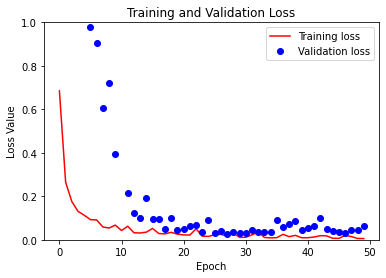

In [101]:
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

epochs = range(EPOCHS)

plt.figure()
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'bo', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.ylim([0, 1])
plt.legend()
plt.show()

In [102]:
model.evaluate(X_test, y_test)

1/1 [==============================] - 0s 136ms/step - loss: 0.0747 - accuracy: 0.9826


[0.07474329322576523, 0.9826178550720215]

In [103]:
y_pred = model.predict(X_test)
y_pred_thresholded = y_pred > 0.5

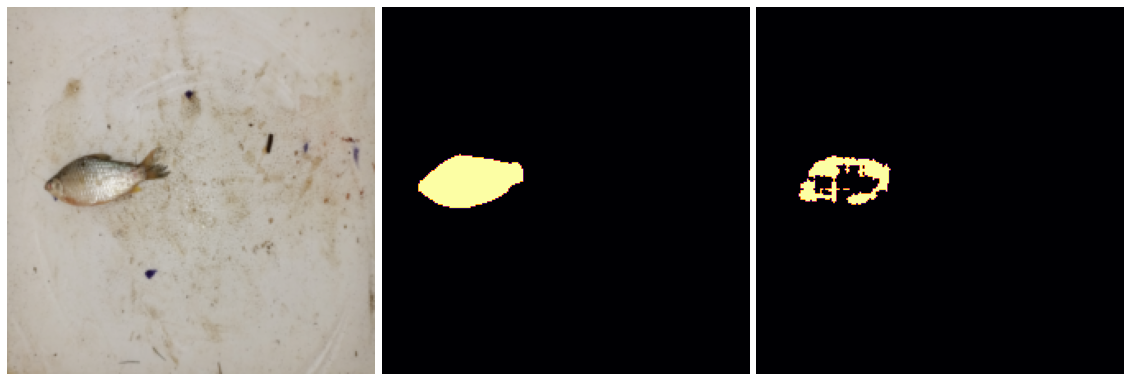

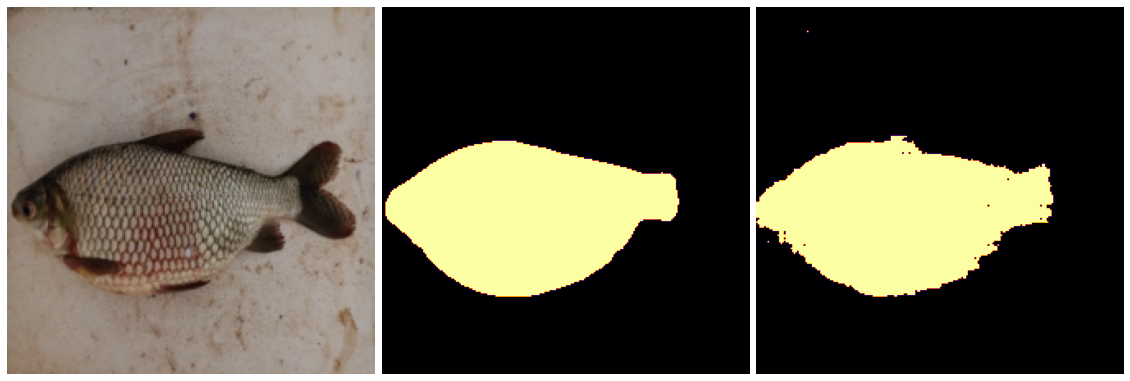

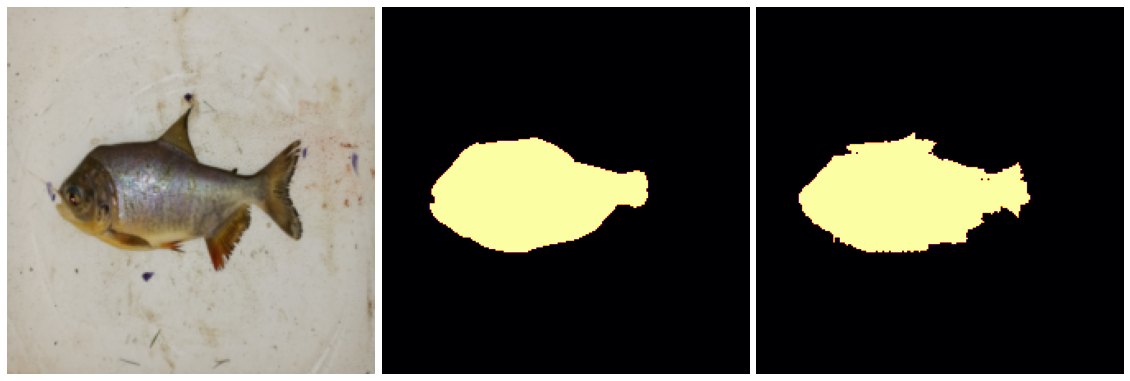

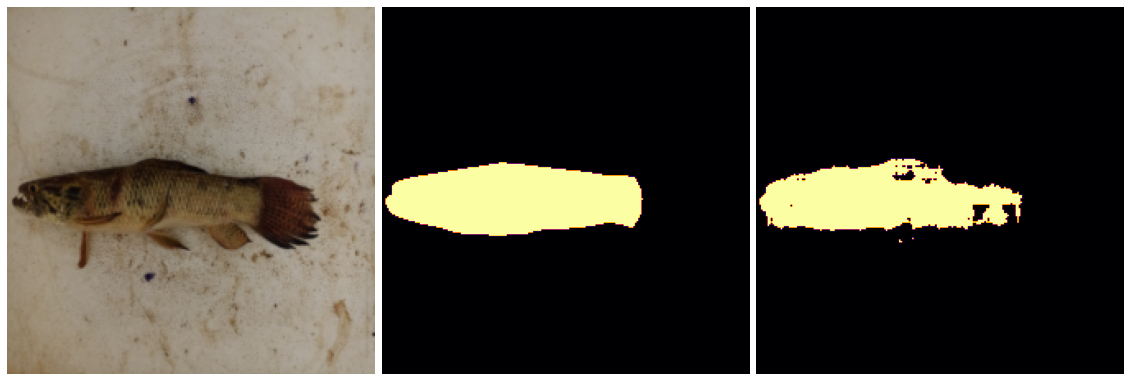

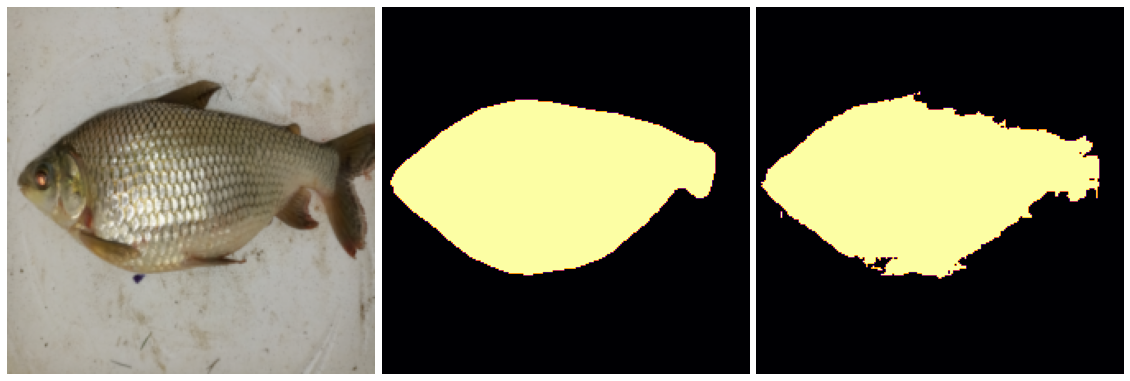

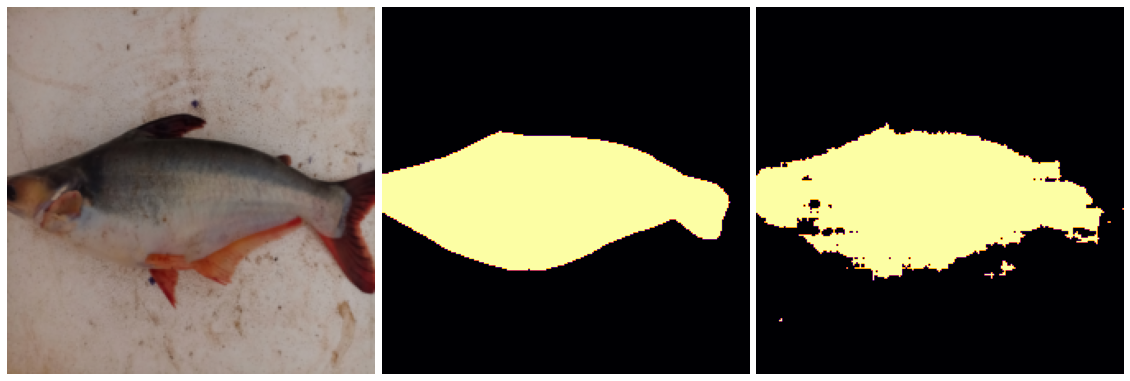

In [104]:
for index in range(len(y_pred)):
    plot([X_test[index], 
          y_test[index], 
          create_mask(y_pred_thresholded[index])], (1, 3))